In [ ]:
# !pip install evaluate -q
# !pip install rouge_score -q
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import evaluate

df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

# Reduce dataset size due to computational reasons
temp = df.copy()
df = temp[:10000]
temp.shape, df.shape
df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [ ]:
# Explore the dataset
df.info()  # Display dataset structure
df.isnull().sum()  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  10000 non-null  object
 1   answer    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


,0
question,0
answer,0


In [ ]:
# Data Cleaning
df = df.drop_duplicates()
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9937 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  9937 non-null   object
 1   answer    9937 non-null   object
dtypes: object(2)
memory usage: 232.9+ KB


In [ ]:
# Data Splitting
# Define features and labels
X = df['question']
y = df['answer']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train)) # Training set size
print(len(X_val)) # Validation set siz

7949
1988


In [ ]:
# Data Preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization
    tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

# Appling preprocessing
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Initializing tokenizer and model
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

class QADataset(Dataset):
    def __init__(self, questions, answers):
        self.inputs = ["question: " + q + " context: " + a for q, a in zip(questions, answers)]
        self.targets = answers

        self.encodings = tokenizer(self.inputs,text_target=list(self.targets),truncation=True,padding='max_length',max_length=512,return_tensors='pt')
        self.encodings['labels'] = self.encodings['input_ids'].clone()

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

# Prepare datasets
train_dataset = QADataset(X_train, y_train)
val_dataset = QADataset(X_val, y_val)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    remove_unused_columns=False

)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train and Evaluate
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-f811c7504ae6>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.049400,1.075871
2,0.911700,1.049341
3,0.849900,1.042267
4,0.987800,1.040503
5,0.916000,1.040501


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=4970, training_loss=1.0931736186236682, metrics={'train_runtime': 6431.2907, 'train_samples_per_second': 6.18, 'train_steps_per_second': 0.773, 'total_flos': 1.038505181184e+16, 'train_loss': 1.0931736186236682, 'epoch': 5.0})

In [ ]:
# Model Evaluation

# Load metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Evaluation function
def evaluate_model(model, dataset, original_answers, tokenizer):
    results = {"rouge": [], "bleu": []}
    for i in range(len(dataset)):
        input_text = original_answers.index[i]
        input_text = str(input_text)
        reference_answer = original_answers.iloc[i]

        input_text = "question: " + input_text + " context: " + reference_answer
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model.generate(**inputs)
        generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if not generated_answer:
            continue

        if not reference_answer.strip() or len(tokenizer(reference_answer)['input_ids']) == 0:
            # skip if reference_answer is empty or just whitespace
            # or contains no tokens according to the tokenizer
            print(f"Skipping index: {i} due to empty reference answer.")
            continue

        results["rouge"].append(rouge.compute(predictions=[generated_answer], references=[reference_answer])['rougeL'])
        results["bleu"].append(bleu.compute(predictions=[generated_answer], references=[reference_answer])['bleu'])

    return results

# Evaluate on validation set
metrics = evaluate_model(model, val_dataset, y_val, tokenizer)
metrics_data = {metric: np.mean(metrics[metric]) if metrics[metric] else 0 for metric in metrics}
print("\nEvaluation Metrics:\n")
print(metrics_data)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Skipping index: 880 due to empty reference answer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Skipping index: 1501 due to empty reference answer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Skipping index: 1721 due to empty reference answer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Skipping index: 1880 due to empty reference answer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Evaluation Metrics:

{'rouge': 0.911596714161425, 'bleu': 0.8108165401016697}


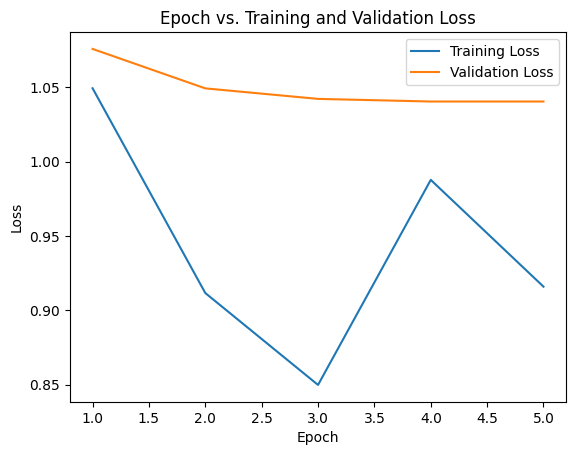

In [ ]:
# Access the training logs to visualisation
log_history = trainer.state.log_history

epochs = []
train_losses = []
val_losses = []

current_epoch = None
current_train_loss = None

for log in log_history:
    if 'epoch' in log:
        current_epoch = log['epoch']

    if 'loss' in log:
        current_train_loss = log['loss']

    if 'eval_loss' in log:
        current_val_loss = log['eval_loss']
        epochs.append(current_epoch)
        train_losses.append(current_train_loss)
        val_losses.append(current_val_loss)

# Create a pandas DataFrame
df = pd.DataFrame({'Epoch': epochs,'Training Loss': train_losses,'Validation Loss': val_losses})

# Plot the data
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')

# Customize the plot
plt.title('Epoch vs. Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

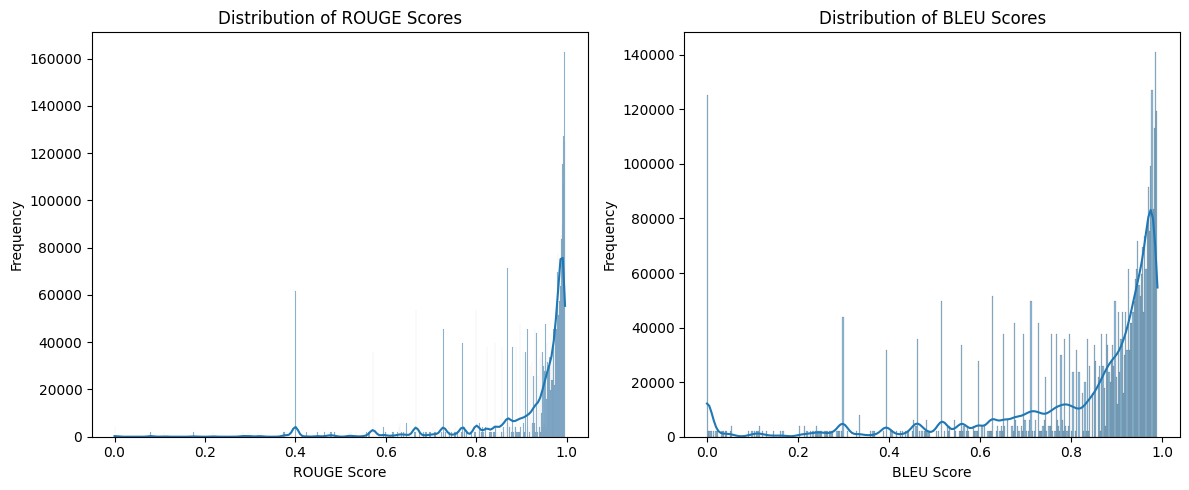

In [ ]:
num_data_points = len(val_dataset)
rouge_scores = np.repeat(metrics["rouge"], num_data_points)
bleu_scores = np.repeat(metrics["bleu"], num_data_points)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROUGE scores
sns.histplot(rouge_scores, kde=True, ax=axes[0])
axes[0].set_title('Distribution of ROUGE Scores')
axes[0].set_xlabel('ROUGE Score')
axes[0].set_ylabel('Frequency')

# BLEU scores
sns.histplot(bleu_scores, kde=True, ax=axes[1])
axes[1].set_title('Distribution of BLEU Scores')
axes[1].set_xlabel('BLEU Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()